This project involves predicting hospital stay length based on various patient, hospital, and treatment features.

1. Imports and Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


2. Data Cleaning and Preprocessing


In [3]:
train_data['Bed Grade'].fillna(train_data['Bed Grade'].median(), inplace=True)
train_data['City_Code_Patient'].fillna(train_data['City_Code_Patient'].mode()[0], inplace=True)
test_data['Bed Grade'].fillna(test_data['Bed Grade'].median(), inplace=True)
test_data['City_Code_Patient'].fillna(test_data['City_Code_Patient'].mode()[0], inplace=True)

# Feature scaling for Admission_Deposit
scaler = StandardScaler()
train_data['Admission_Deposit'] = scaler.fit_transform(train_data[['Admission_Deposit']])
test_data['Admission_Deposit'] = scaler.transform(test_data[['Admission_Deposit']])

train_data.drop(['case_id', 'patientid'], axis=1, inplace=True)
test_data.drop(['case_id', 'patientid'], axis=1, inplace=True)


3. Feature Engineering

In [7]:
# Adding interaction terms for hospital and department
train_data['Hospital_Department_Interaction'] = train_data['Hospital_code'].astype(str) + "_" + train_data['Department'].astype(str)
test_data['Hospital_Department_Interaction'] = test_data['Hospital_code'].astype(str) + "_" + test_data['Department'].astype(str)

label_cols = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type',
              'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Hospital_Department_Interaction']

le = LabelEncoder()
for col in label_cols:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])


4. EDA

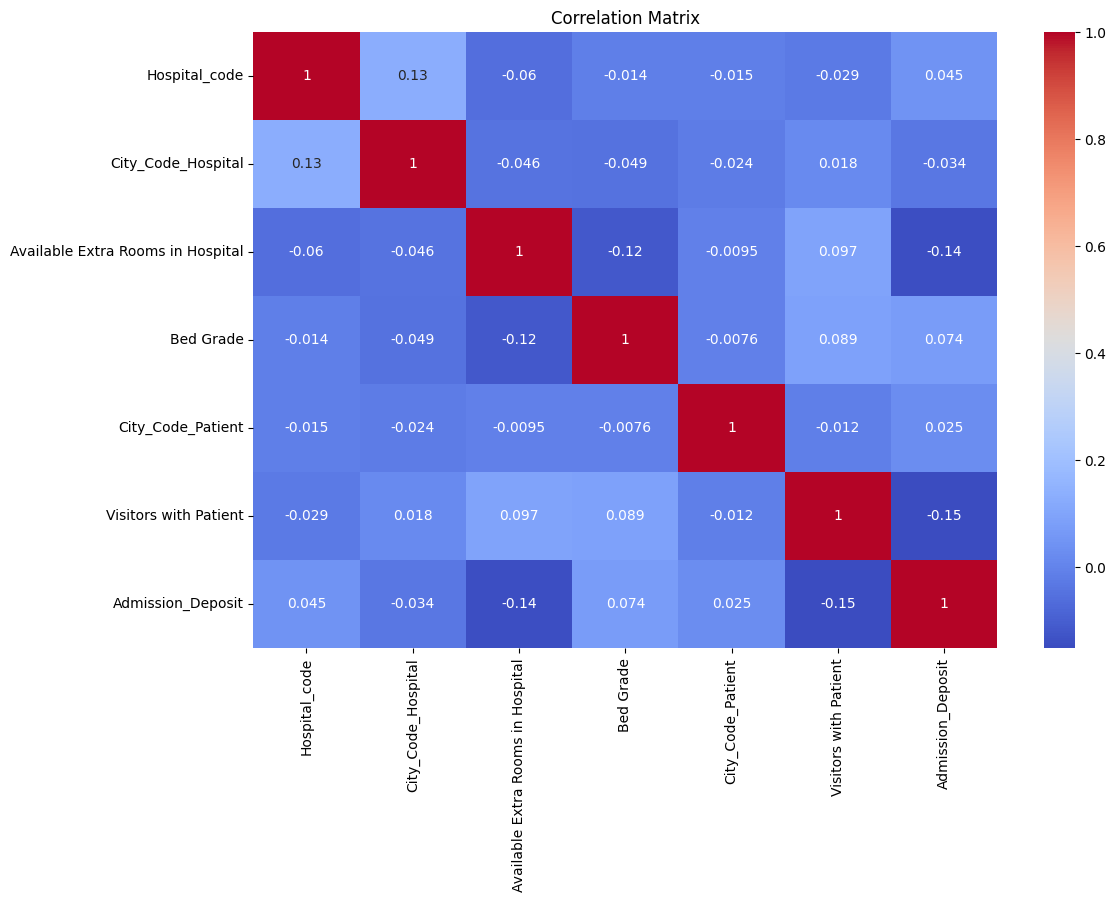

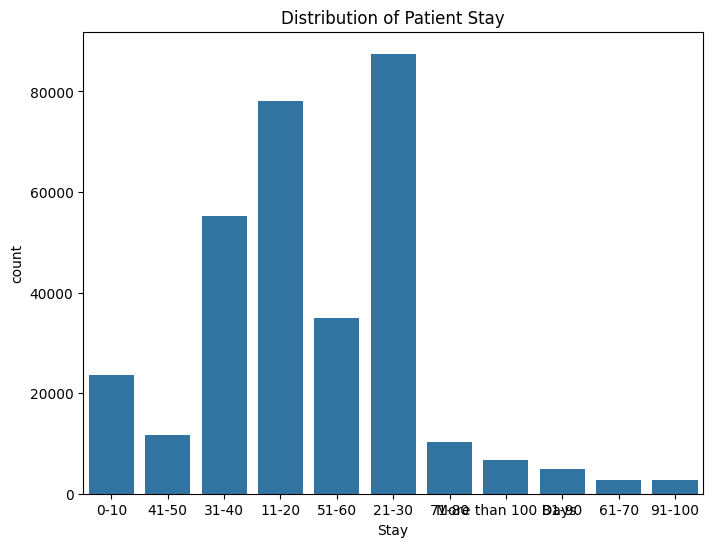

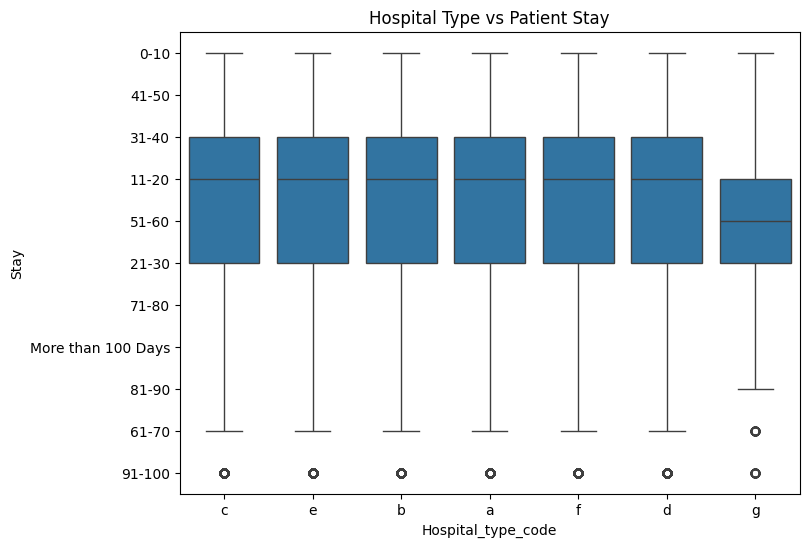

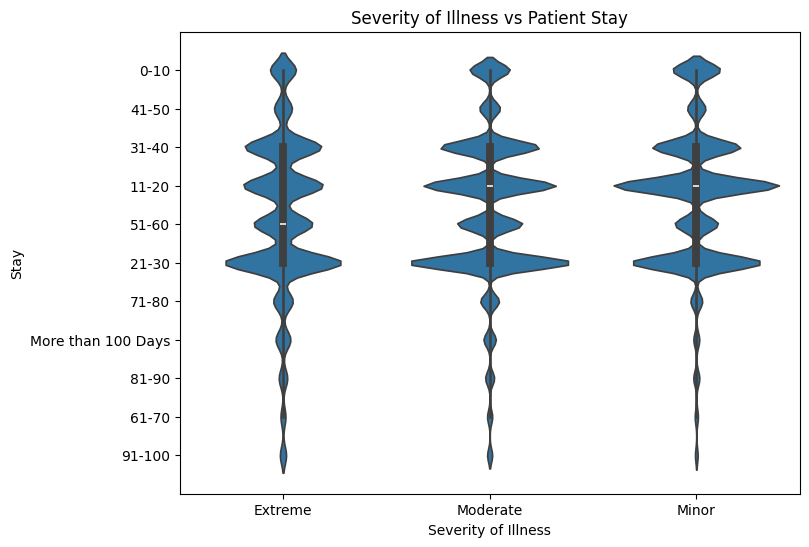

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Correlation Matrix
plt.figure(figsize=(12, 8))

numerical_features = train_data.select_dtypes(include=np.number).columns
corr_matrix = train_data[numerical_features].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 2. Distribution of Stay
plt.figure(figsize=(8, 6))
sns.countplot(x='Stay', data=train_data)
plt.title('Distribution of Patient Stay')
plt.show()

# 3. Hospital Type vs Stay
plt.figure(figsize=(8, 6))
sns.boxplot(x='Hospital_type_code', y='Stay', data=train_data)
plt.title('Hospital Type vs Patient Stay')
plt.show()

# 4. Severity of Illness vs Stay
plt.figure(figsize=(8, 6))
sns.violinplot(x='Severity of Illness', y='Stay', data=train_data)
plt.title('Severity of Illness vs Patient Stay')
plt.show()


I tried many models like Random Forest, XGBoost, CatBoost, LightGBM to bring the good model to make the predictions but due to the complexity of the dataset, the models are not supporting the satisfying accuracy in order to make the accurate predictions. So, after many trails and erros in choosing the suitable ML model for the predictions I have come to few conclusions regarding modifying/engineering the data.

These are the few root causes I was able to find:

*   Severe Class Imbalance: The majority of classes (e.g., 11-20 days, 21-30 days) have far more examples than others, leading to poor performance on underrepresented classes.
*   Feature Relevance: The features the data currently have may not be capturing the critical patterns in the data effectively.
* Complexity of Target Classes: Predicting the exact range of days for hospital stays is inherently challenging. Some categories are inherently difficult to distinguish based on available features.

So, few of the strategies I was able to summon are:

* Simplify Target Classes: Instead of predicting 11 distinct classes for hospital stay lengths, we can group the target variable into broader categories (e.g., short, medium, long stays). This will reduce the complexity of the problem.
* Feature Selection and Removal: Removing irrelevant or low-importance features and focus on core predictors. We can use feature importance from LightGBM or another method to select the most relevant features.
* Model Stacking or Ensembling: Combining models (here I used LightGBM) using a meta-model to improve performance on different sections of the data.

5. Simplifying the Target Variable

In [8]:
# By grouping the stay durations into fewer buckets (for example: Short, Medium, and Long stays), the model may perform better.
# Simplify the target variable into broader categories
def simplify_stay_category(stay):
    if stay in ['0-10', '11-20']:
        return 'Short'
    elif stay in ['21-30', '31-40', '41-50']:
        return 'Medium'
    else:
        return 'Long'

# Apply the simplified function to the Stay column
train_data['Stay_Simplified'] = train_data['Stay'].apply(simplify_stay_category)

# Encode the simplified target
le_target_simple = LabelEncoder()
y_simple_encoded = le_target_simple.fit_transform(train_data['Stay_Simplified'])

X = train_data.drop(['Stay', 'Stay_Simplified'], axis=1)
y = y_simple_encoded


In [9]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


6. Model Training (LightGBM)

In [11]:
# Training LightGBM with class weights
lgb_model = LGBMClassifier(class_weight=class_weight_dict, random_state=42, n_estimators=500, learning_rate=0.05)

lgb_model.fit(X_train, y_train)

y_pred_val_encoded = lgb_model.predict(X_val)

# Decode predictions back to original labels
y_pred_val = le_target_simple.inverse_transform(y_pred_val_encoded)
y_val_decoded = le_target_simple.inverse_transform(y_val)

print("Accuracy: ", accuracy_score(y_val_decoded, y_pred_val))
print("Classification Report:\n", classification_report(y_val_decoded, y_pred_val))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Accuracy:  0.6045565883682954
Classification Report:
               precision    recall  f1-score   support

        Long       0.60      0.80      0.68     12460
      Medium       0.69      0.48      0.57     30879
       Short       0.54      0.68      0.60     20349

    accuracy                           0.60     63688
   macro avg       0.61      0.65      0.62     63688
weighted avg       0.62  

7. Feature Selection and Importance Analysis

Analysing the importance of the features in the LightGBM pov.

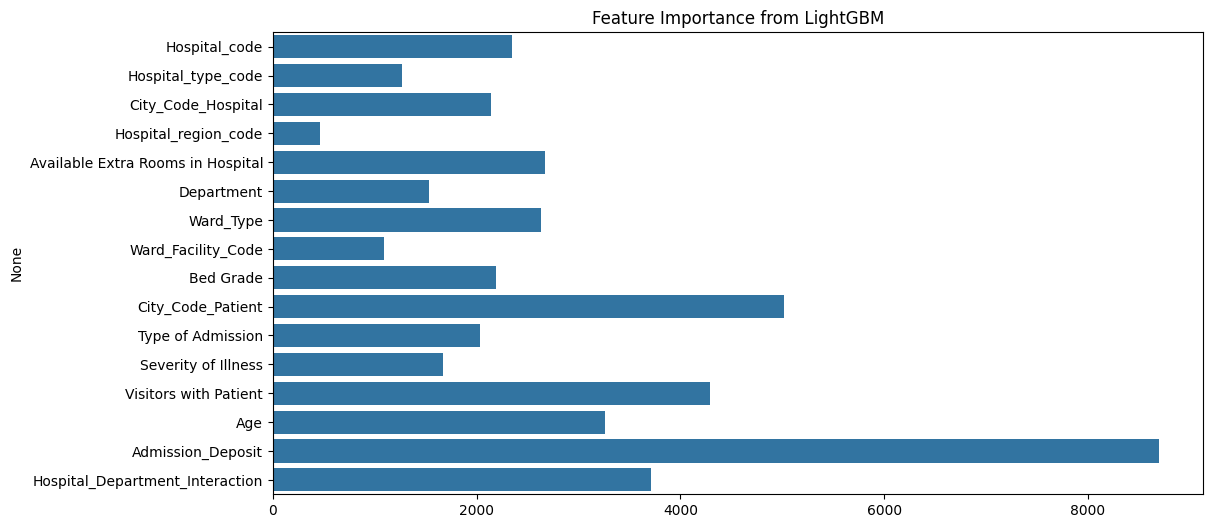

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 586
[LightGBM] [Info] Number of data points in the train set: 254750, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Updated Accuracy:  0.6045565883682954
Updated Classification Report:
               precision    recall  f1-score   support

        Long       0.60      0.80      0.68     12460
      Medium       0.69      0.48      0.57     30879
       Short       0.54      0.68      0.60     20349

    accuracy                           0.60     63688
   macro avg       0.61      0.65      0.62     63688
weighted 

In [13]:
# Feature importance from LightGBM
feature_importances = lgb_model.feature_importances_
features = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance from LightGBM')
plt.show()

# Optionally remove low-importance features and retrain
important_features = [features[i] for i in range(len(features)) if feature_importances[i] > 10]
X_train = X_train[important_features]
X_val = X_val[important_features]

# Retrain model with selected features
lgb_model.fit(X_train, y_train)
y_pred_val_encoded = lgb_model.predict(X_val)
y_pred_val = le_target_simple.inverse_transform(y_pred_val_encoded)
print("Updated Accuracy: ", accuracy_score(y_val_decoded, y_pred_val))
print("Updated Classification Report:\n", classification_report(y_val_decoded, y_pred_val))


Summary:

1. Simplified Target: We are grouping the stay length into broader categories (Short, Medium, and Long), reducing the complexity of the classification task.
Feature Selection:

2. Only the most important features (based on feature importance from LightGBM) will be used to train the model. This reduces noise and improves model efficiency.

8. Test Predictions and Submission

In [16]:
# Ensure that case_id is present in the test data
# reloading the original test data and retain 'case_id'
original_test_data = pd.read_csv('test.csv')

submission = pd.DataFrame({'case_id': original_test_data['case_id'], 'Stay': test_predictions})


In [18]:
# Make predictions on the test set
test_data_selected = test_data[important_features]  # Use important features selected earlier
test_predictions_encoded = lgb_model.predict(test_data_selected)
test_predictions = le_target_simple.inverse_transform(test_predictions_encoded)


In [23]:
# Instead of using test_data['case_id'], use the original_test_data DataFrame
submission = pd.DataFrame({'case_id': original_test_data['case_id'], 'Stay': test_predictions})

# Saving submission to CSV
submission.to_csv('hospital_stay_predictions_final.csv', index=False)

from google.colab import files

files.download('hospital_stay_predictions_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
pd.read_csv('hospital_stay_predictions_final.csv').head()

,case_id,Stay
0,318439,Short
1,318440,Long
2,318441,Medium
3,318442,Medium
4,318443,Long


from matplotlib import pyplot as plt
_df_0['case_id'].plot(kind='hist', bins=20, title='case_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Stay').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['case_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'case_id'}, axis=1)
              .sort_values('case_id', ascending=True))
  xs = counted['case_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('case_id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Stay')):
  _plot_series(series, series_name, i)
  fig.legend(title='Stay', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('case_id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['case_id'].plot(kind='line', figsize=(8, 4), title='case_id')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['Stay'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='case_id', y='Stay', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

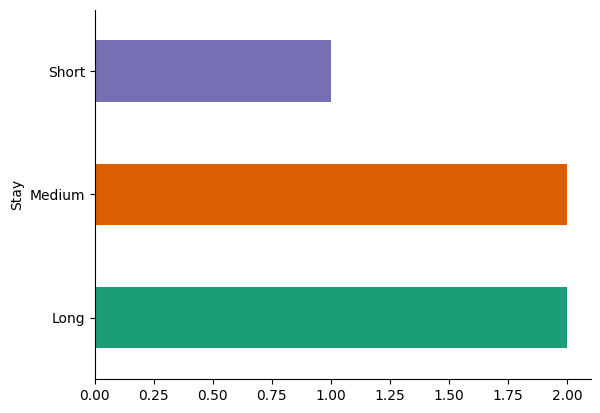

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Stay').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Areas of Improvement -

We can further tune the model to improve performance. There are several techniques for hyperparameter tuning that can help refine your model and potentially increase accuracy or reduce overfitting.

1. Grid Search or Random Search for Hyperparameter Tuning: We can use GridSearchCV or RandomizedSearchCV to find the best combination of hyperparameters. These methods systematically search for the best parameters for your model.

2. With Different Sets of Parameters: Parameters such as the number of estimators, learning rate, tree depth, and regularization terms can be tuned.
For LightGBM, we can tune parameters like num_leaves, max_depth, learning_rate, n_estimators, and others.